BEST VERSION

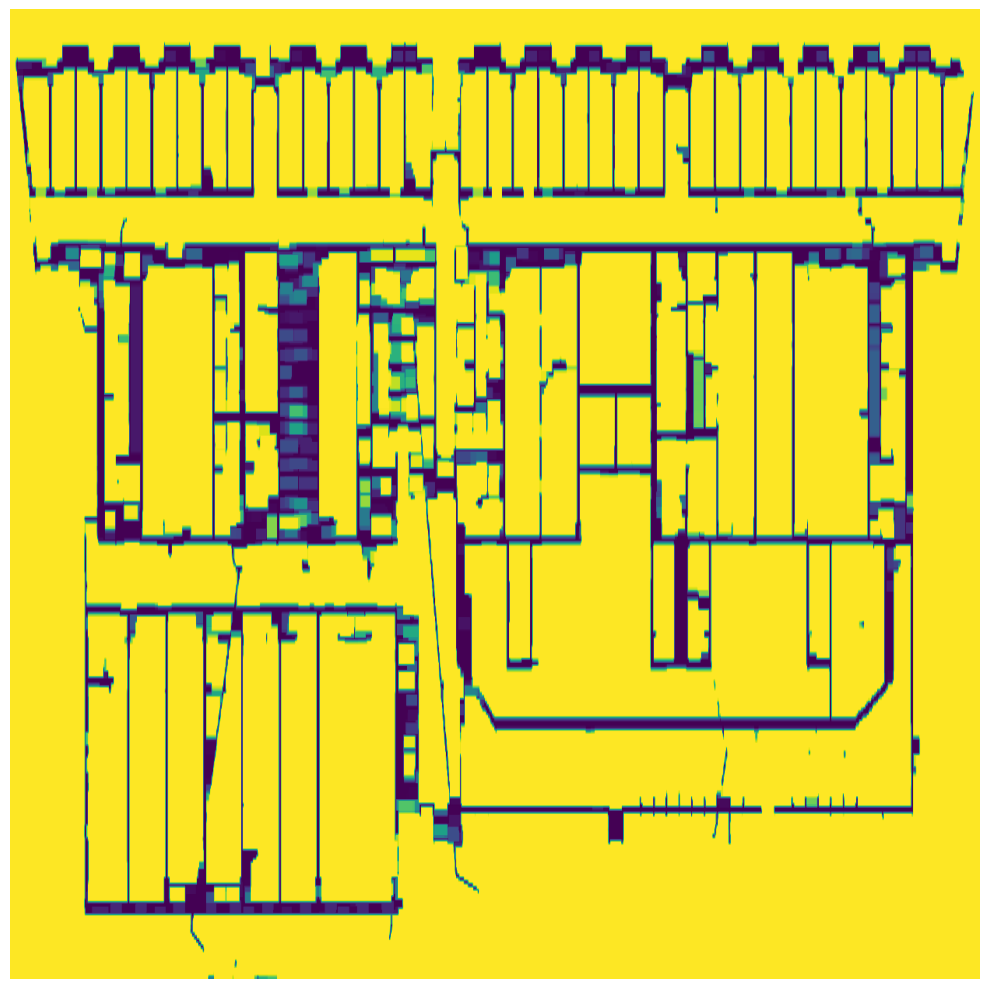

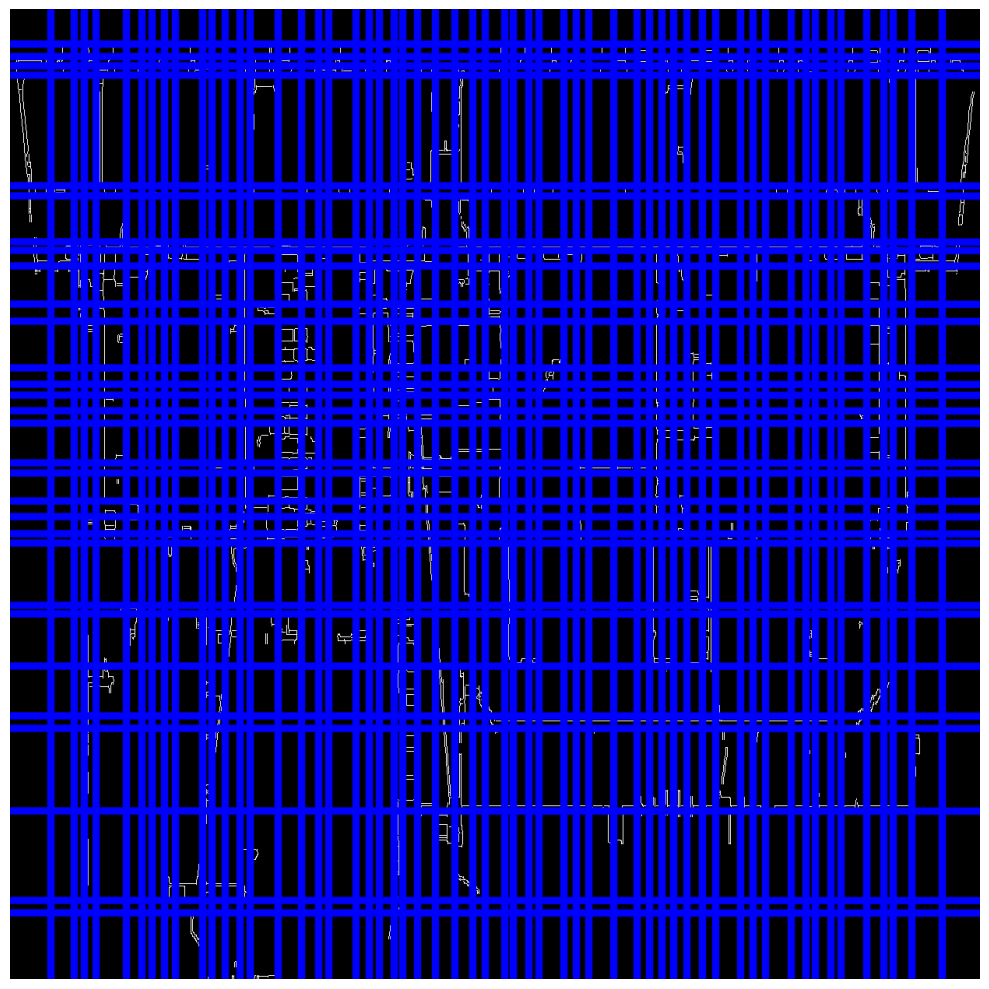

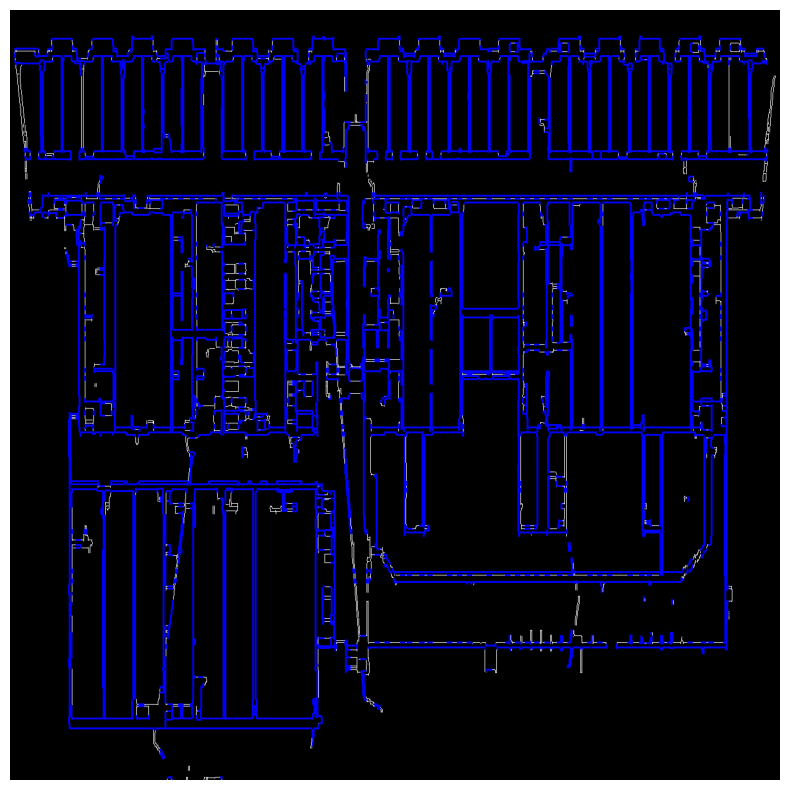

(315, 1246)


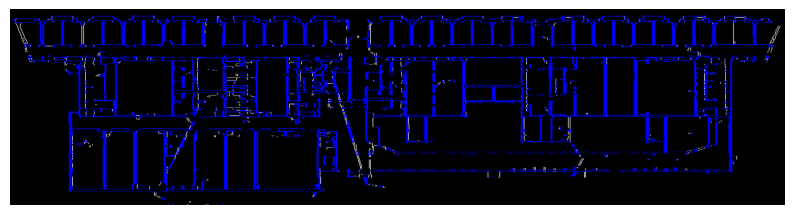

In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# ------------
# ------------
filename = 'img/reassembled_E2_2.png'
src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
if src is None:
    print('Error opening image!')
    print('Usage: hough_lines.py [image_name] \n')
    exit()

# Resize the image to make it square
max_dim = max(src.shape[:2])
src_square = cv.resize(src, (max_dim, max_dim), interpolation=cv.INTER_LINEAR)

# Apply morphological opening
kernel = np.ones((5,5),np.uint8)
src_square = cv.morphologyEx(src_square, cv.MORPH_OPEN, kernel, iterations=3)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(src_square)
plt.axis('off')
plt.tight_layout()
plt.show()

# Edge detection
dst = cv.Canny(src_square, 50, 200, None, 3)

# Convert to BGR image for display
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

# Detect lines in the entire image
lines = cv.HoughLines(dst, 0.1, np.pi / 180, max_dim//10, None, 0, 0)
all_lines = []
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        max_len = int(np.sqrt(2) * max_dim)
        pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
        pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
        all_lines.append((pt1, pt2, theta))

# Non-maximum suppression
strong_lines = np.zeros([len(all_lines),1,2])
n2 = 0
for n1 in range(0, len(all_lines)):
    pt1, pt2, theta = all_lines[n1]
    rho = abs((pt2[1] - pt1[1]) * pt1[0] - (pt2[0] - pt1[0]) * pt1[1]) / np.sqrt((pt2[1] - pt1[1])**2 + (pt2[0] - pt1[0])**2)
    if n1 == 0:
        strong_lines[n2] = [[rho, theta]]
        n2 = n2 + 1
    else:
        if rho < 0:
            rho *= -1
            theta -= np.pi
        closeness_rho = np.isclose(rho, strong_lines[0:n2,0,0], atol=10)  # Decrease atol for rho
        closeness_theta = np.isclose(theta, strong_lines[0:n2,0,1], atol=np.pi/45)  # Decrease atol for theta
        closeness = np.all([closeness_rho, closeness_theta], axis=0)
        if not any(closeness):
            strong_lines[n2] = [[rho, theta]]
            n2 = n2 + 1

cdst_copy = cdst.copy()

# Draw lines on the image
for line in strong_lines[:n2]:
    rho, theta = line[0]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    max_len = int(np.sqrt(2) * max_dim)
    pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
    pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
    angle_deg = theta * 180 / np.pi
    tolerance = 0.1  # Adjust tolerance as needed
    if (abs(angle_deg) <= tolerance) or (abs(abs(angle_deg) - 90) <= tolerance) or (abs(abs(angle_deg) - 180) <= tolerance) or (abs(abs(angle_deg) - 270) <= tolerance):
        # color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        color  = (0, 0, 255)
        cv.line(cdst, pt1, pt2, color, 7, cv.LINE_AA)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cdst)
plt.axis('off')
plt.tight_layout()
plt.show()

# Accumulate all points from each line found by Hough transform
all_hough_points = []


# Create a blank white image
blank_image = np.full((max_dim, max_dim, 3), (255, 255, 255), dtype=np.uint8)

for y in range(cdst.shape[0]):
    for x in range(cdst.shape[1]):
        if np.array_equal(cdst[y, x], [0, 0, 255]):
            all_hough_points.append((x, y))

# for x,y in all_hough_points:
#     blank_image[y,x] = (0,0,255)

# # Show the result
# plt.figure(figsize=(10, 10))
# plt.imshow(blank_image)
# plt.axis('off')
# plt.show()

for x, y in all_hough_points:
    if y+1 in range(cdst_copy.shape[0]) and y-1 in range(cdst_copy.shape[0]) and x+1 in range(cdst_copy.shape[0]) and x-1 in range(cdst_copy.shape[0]) :
        if np.array_equal(cdst_copy[y, x], [255, 255, 255]):
            cdst_copy[y,x] = (0,0,255)
            cdst_copy[y+1,x+1] = (0,0,255)
            cdst_copy[y+1,x-1] = (0,0,255)
            cdst_copy[y-1,x-1] = (0,0,255)
            cdst_copy[y-1,x+1] = (0,0,255)

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(cdst_copy)
plt.axis('off')
plt.show()

print(src.shape)
final_image = cv.resize(cdst_copy, (src.shape[1], src.shape[0]), interpolation=cv.INTER_LINEAR)

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.show()

Separate hough lines and floorplan

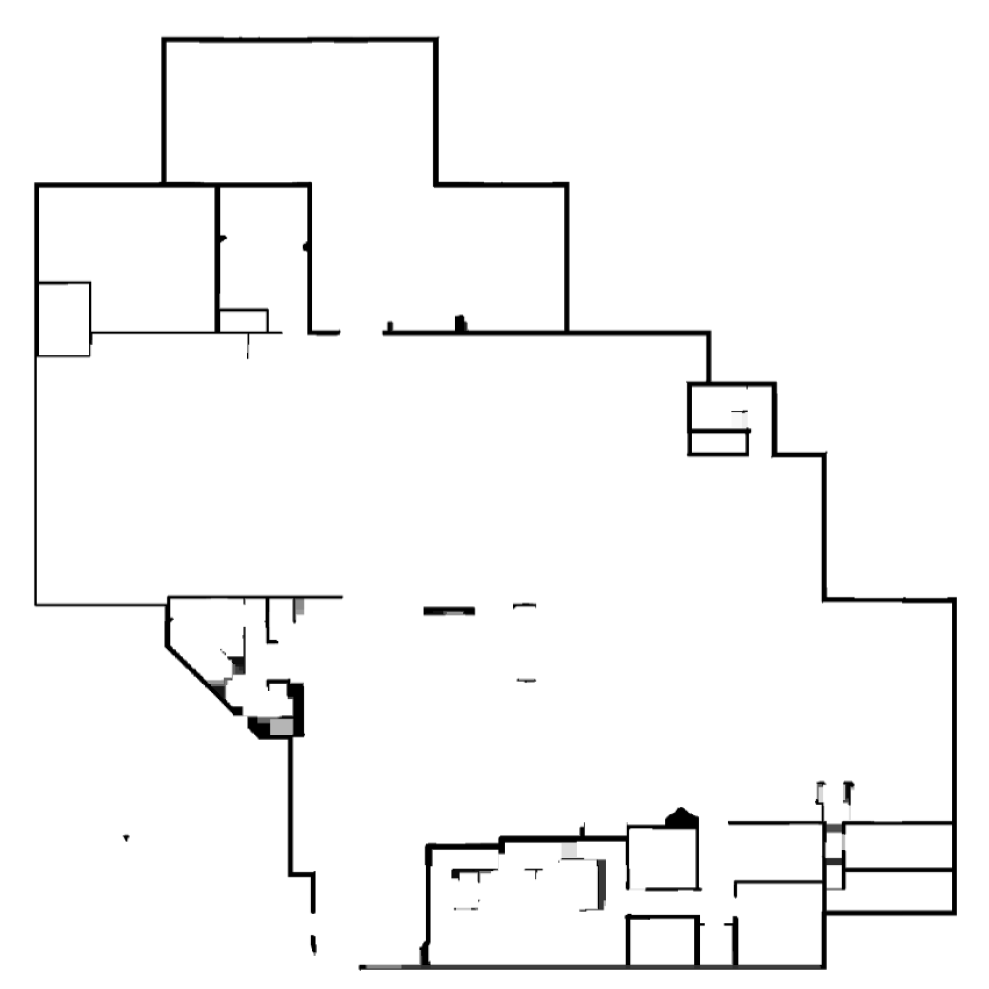

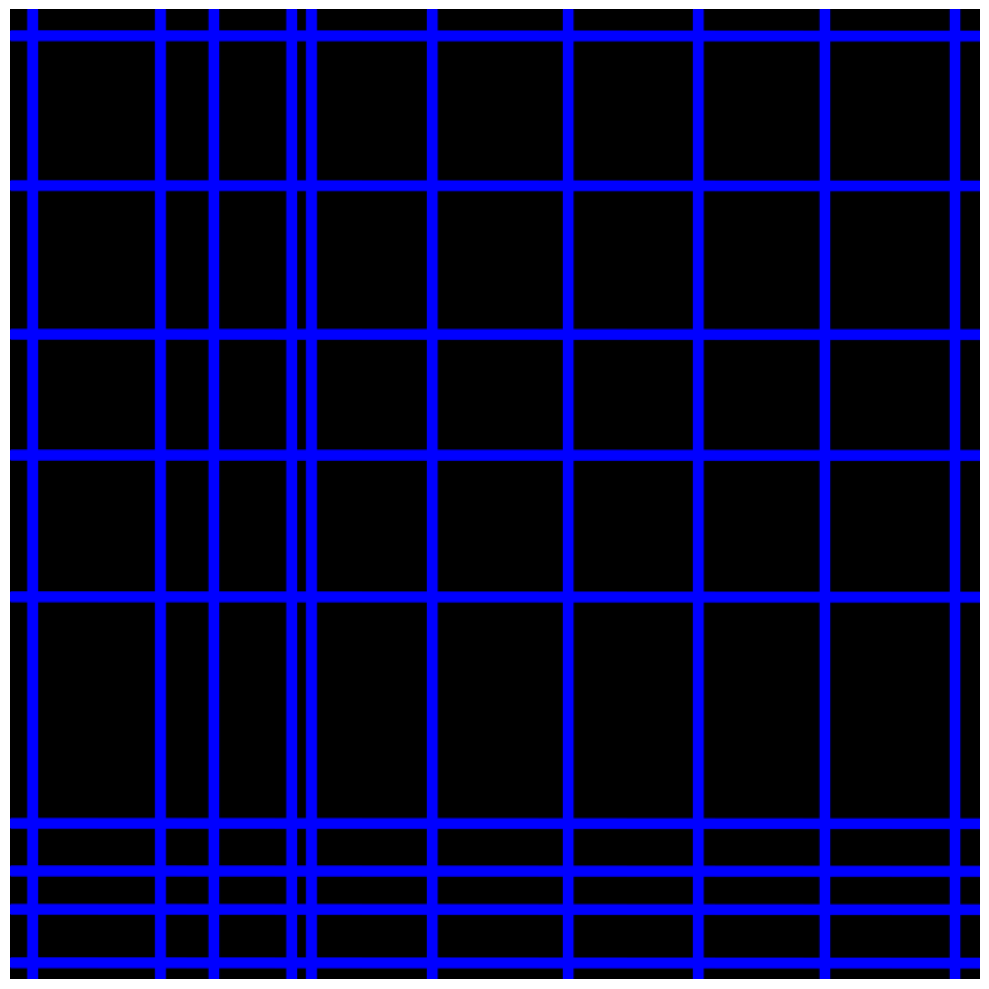

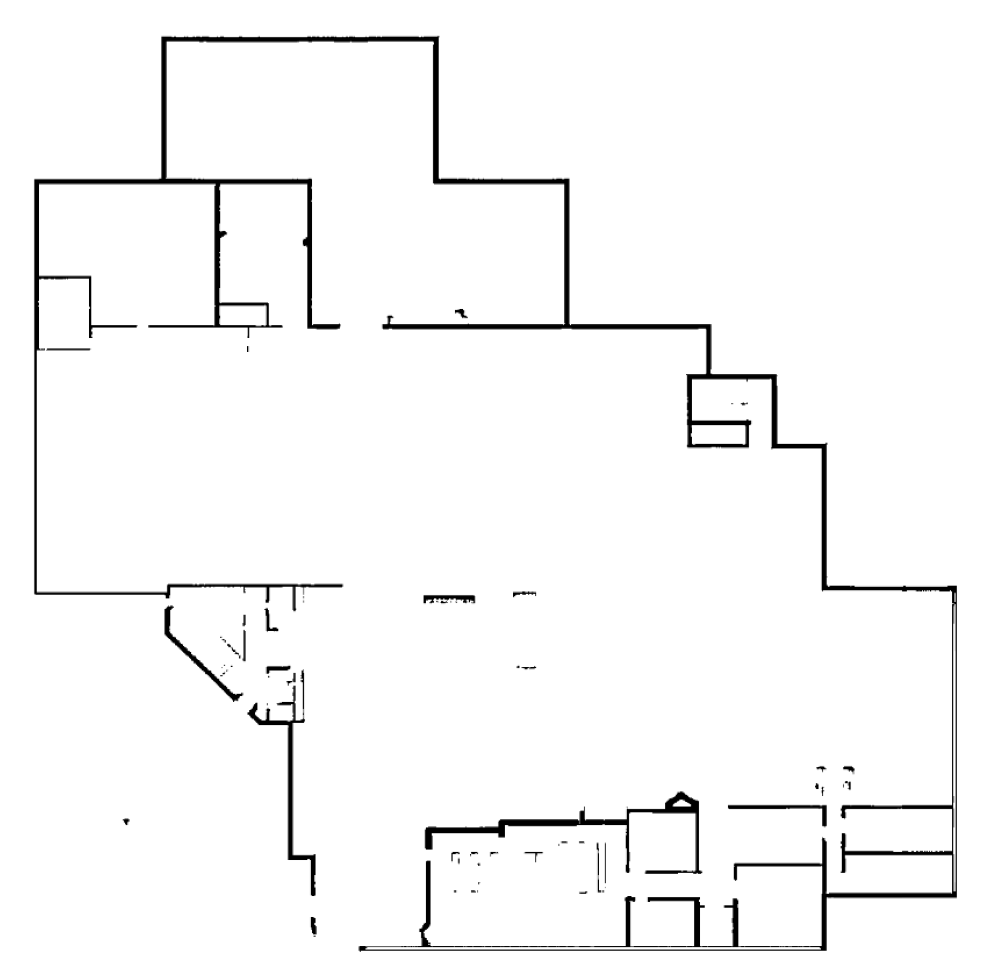

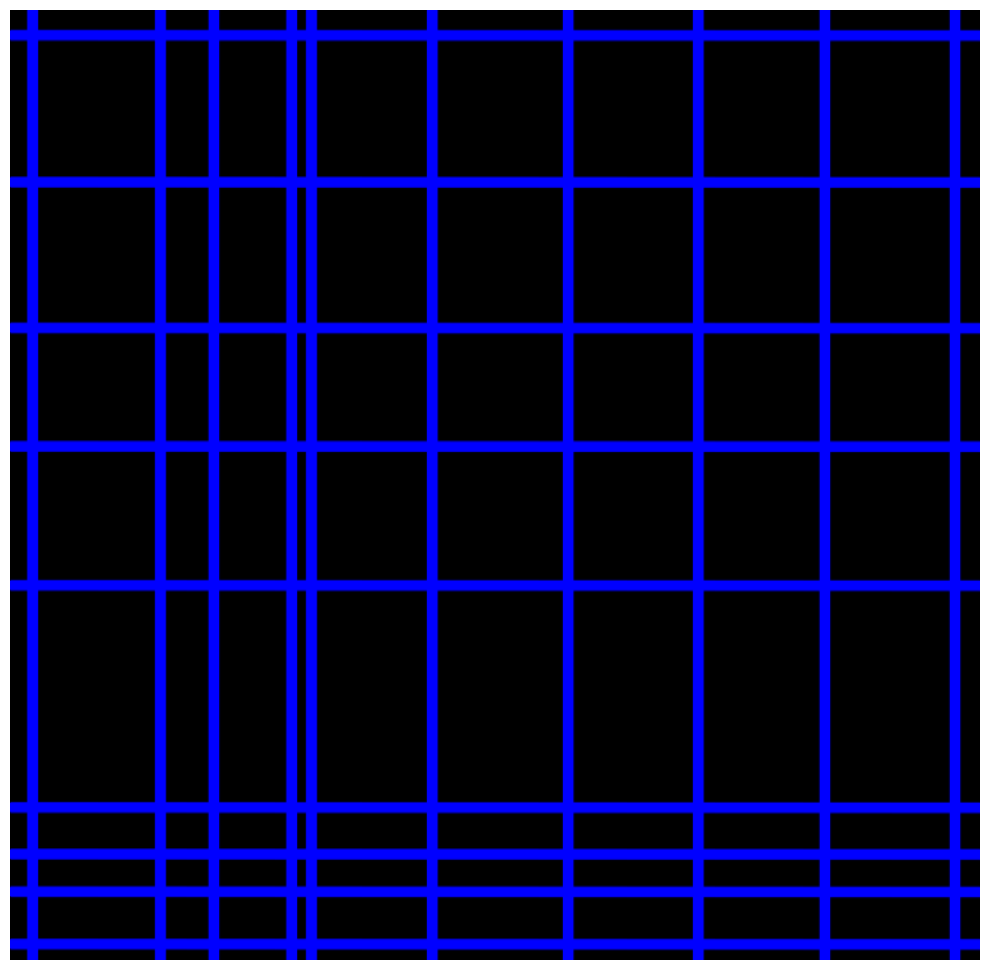

In [6]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# ------------
# ------------
filename = 'img/reassembled_SE2.png'
src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
if src is None:
    print('Error opening image!')
    print('Usage: hough_lines.py [image_name] \n')
    exit()

# Resize the image to make it square
max_dim = max(src.shape[:2])
src_square = cv.resize(src, (max_dim, max_dim), interpolation=cv.INTER_LINEAR)

# Apply morphological opening
kernel = np.ones((5,5),np.uint8)
src_square = cv.morphologyEx(src_square, cv.MORPH_OPEN, kernel, iterations=3)

# Display the floorplan
plt.figure(figsize=(10, 10))
plt.imshow(src_square, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Edge detection
dst = cv.Canny(src_square, 50, 200, None, 3)

# Convert to BGR image for display
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

# Detect lines in the entire image
lines = cv.HoughLines(dst, 0.1, np.pi / 180, max_dim//10, None, 0, 0)
all_lines = []
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        max_len = int(np.sqrt(2) * max_dim)
        pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
        pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
        all_lines.append((pt1, pt2, theta))

# Non-maximum suppression
strong_lines = np.zeros([len(all_lines),1,2])
n2 = 0
for n1 in range(0, len(all_lines)):
    pt1, pt2, theta = all_lines[n1]
    rho = abs((pt2[1] - pt1[1]) * pt1[0] - (pt2[0] - pt1[0]) * pt1[1]) / np.sqrt((pt2[1] - pt1[1])**2 + (pt2[0] - pt1[0])**2)
    if n1 == 0:
        strong_lines[n2] = [[rho, theta]]
        n2 = n2 + 1
    else:
        if rho < 0:
            rho *= -1
            theta -= np.pi
        closeness_rho = np.isclose(rho, strong_lines[0:n2,0,0], atol=10)  # Decrease atol for rho
        closeness_theta = np.isclose(theta, strong_lines[0:n2,0,1], atol=np.pi/45)  # Decrease atol for theta
        closeness = np.all([closeness_rho, closeness_theta], axis=0)
        if not any(closeness):
            strong_lines[n2] = [[rho, theta]]
            n2 = n2 + 1

# Create a blank image for drawing lines
blank_image = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)

# Draw lines on the blank image
for line in strong_lines[:n2]:
    rho, theta = line[0]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    max_len = int(np.sqrt(2) * max_dim)
    pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
    pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
    angle_deg = theta * 180 / np.pi
    tolerance = 0.1  # Adjust tolerance as needed
    if (abs(angle_deg) <= tolerance) or (abs(abs(angle_deg) - 90) <= tolerance) or (abs(abs(angle_deg) - 180) <= tolerance) or (abs(abs(angle_deg) - 270) <= tolerance):
        color  = (0, 0, 255)  # Blue color
        cv.line(blank_image, pt1, pt2, color, 7, cv.LINE_AA)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(blank_image)
plt.axis('off')
plt.tight_layout()
plt.show()

# Resize the original image back to its original dimensions
original_image = cv.resize(src, (src.shape[1], src.shape[0]), interpolation=cv.INTER_LINEAR)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Squeeze the Hough lines image to fit the original dimensions
hough_lines_original = cv.resize(blank_image, (src.shape[1], src.shape[0]), interpolation=cv.INTER_LINEAR)

# Display the squeezed Hough lines image
plt.figure(figsize=(10, 10))
plt.imshow(hough_lines_original)
plt.axis('off')
plt.tight_layout()
plt.show()

No tiling without non-maximum suppression, no diagonals

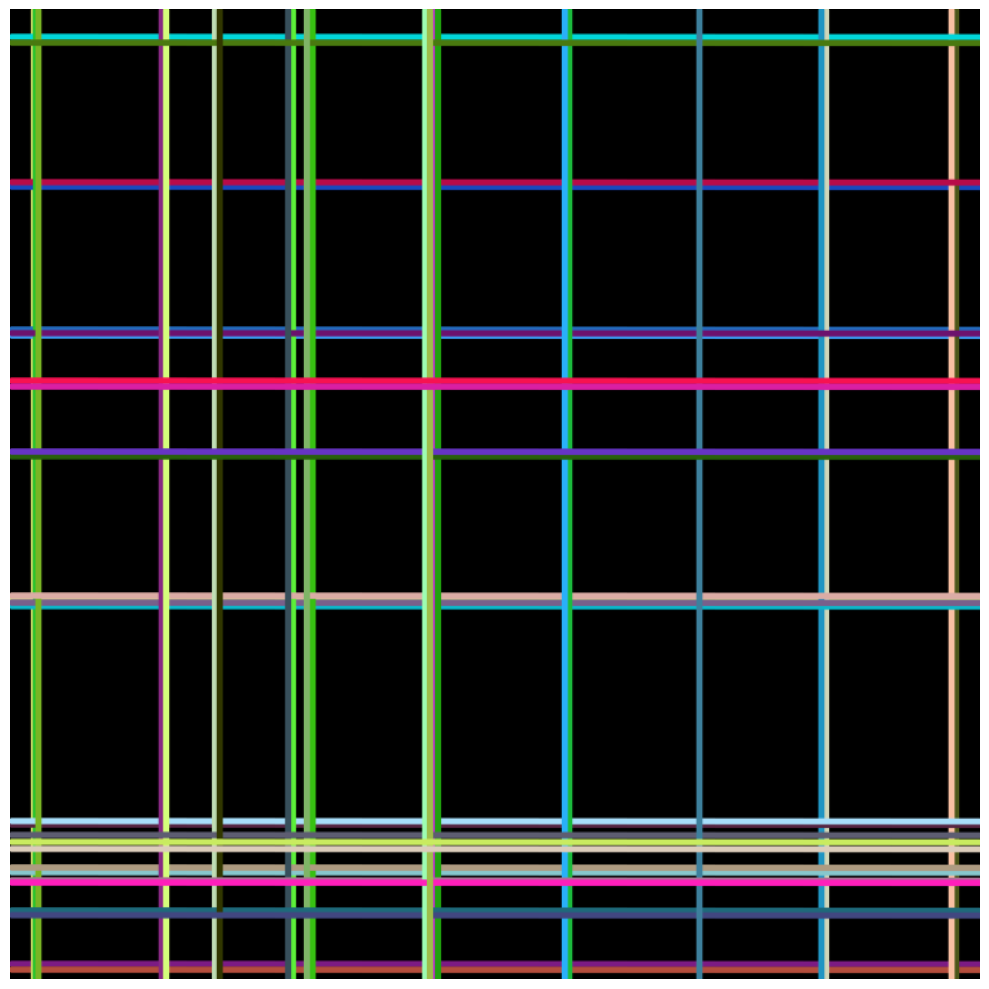

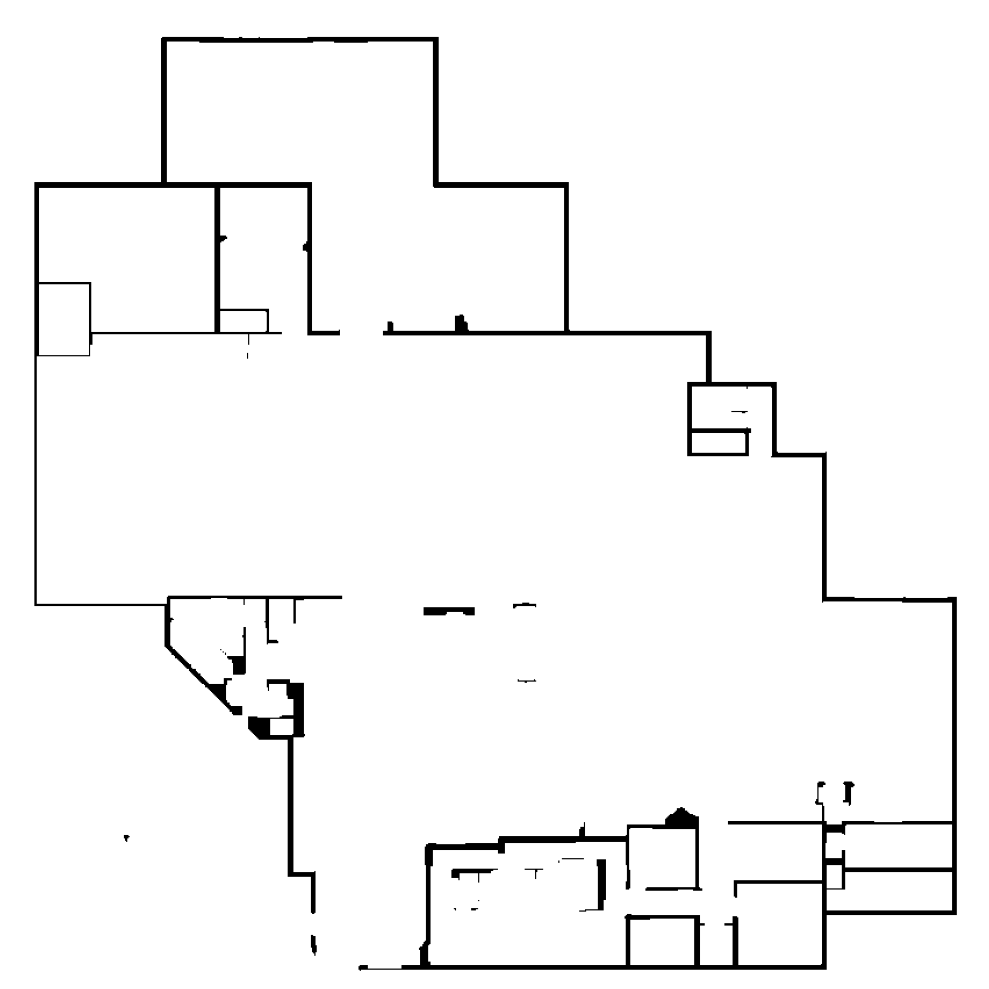

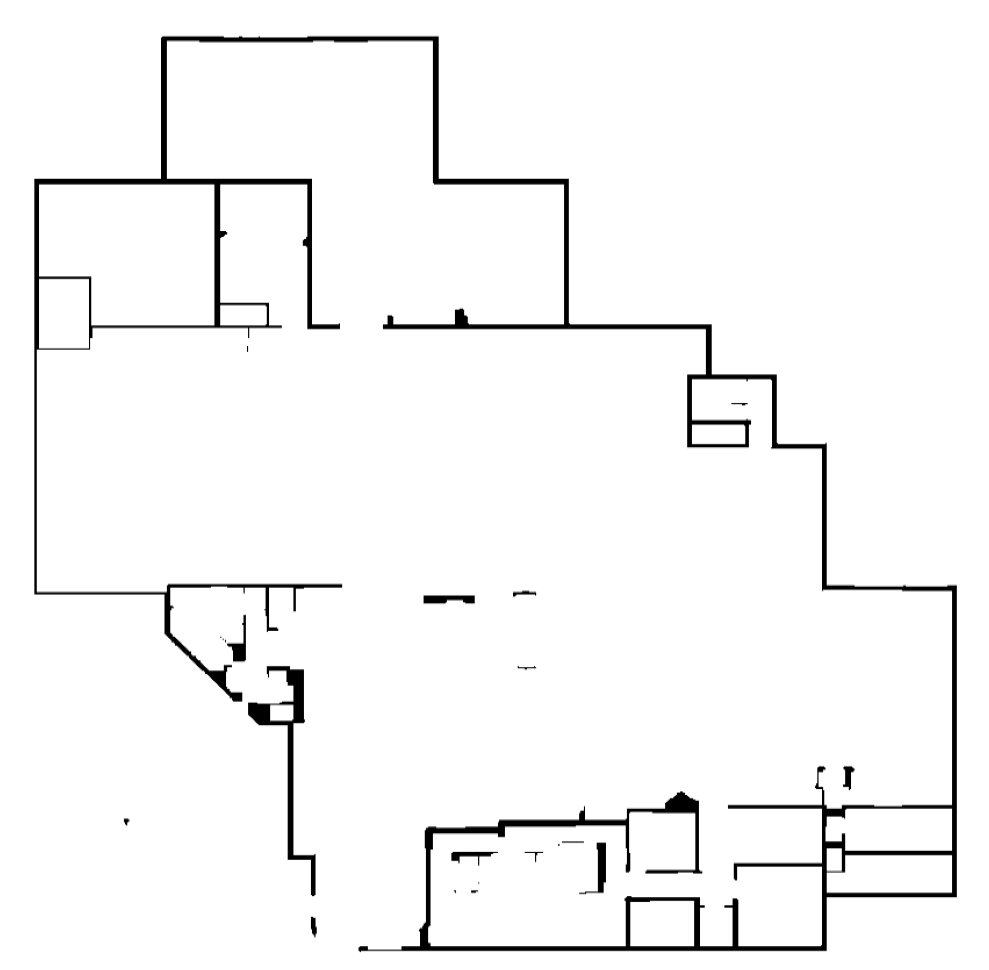

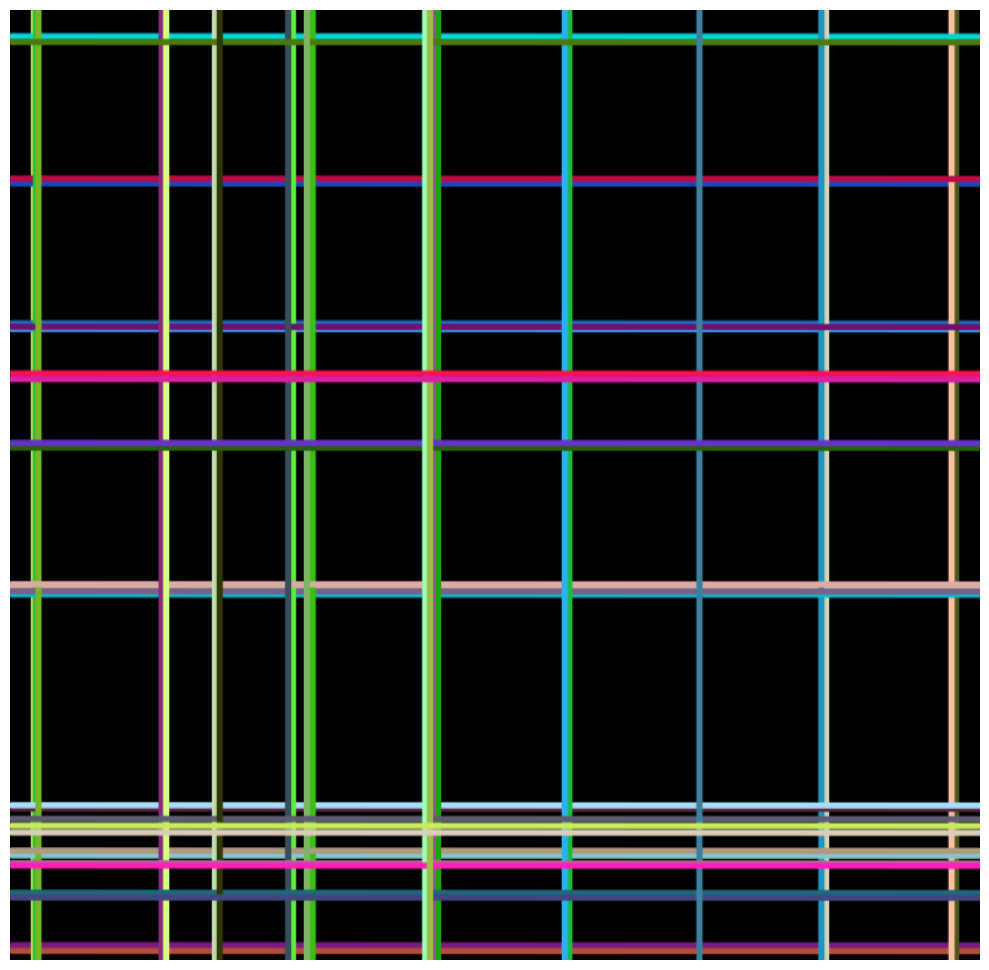

In [1]:
import cv2 as cv
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# ------------
# ------------
filename = 'img/reassembled_SE2.png'
src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
if src is None:
    print('Error opening image!')
    print('Usage: hough_lines.py [image_name] \n')
    exit()

# Store the original dimensions
original_height, original_width = src.shape

# Resize the image to make it square
max_dim = max(src.shape[:2])
src_square = cv.resize(src, (max_dim, max_dim), interpolation=cv.INTER_LINEAR)

# Apply morphological opening
kernel = np.ones((5,5),np.uint8)
src_square = cv.morphologyEx(src_square, cv.MORPH_OPEN, kernel, iterations=3)

# Edge detection
dst = cv.Canny(src_square, 50, 200, None, 3)

# Create a blank image for Hough lines
hough_lines = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)

# Detect lines
lines = cv.HoughLines(dst, 1, np.pi / 180, max_dim//12, None, 0, 0)
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        max_len = int(np.sqrt(2) * max_dim)
        pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
        pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
        # Check if the line is horizontal or vertical
        angle_deg = theta * 180 / np.pi
        tolerance = 0.1  # Adjust tolerance as needed
        if (abs(angle_deg) <= tolerance) or (abs(abs(angle_deg) - 90) <= tolerance) or (abs(abs(angle_deg) - 180) <= tolerance) or (abs(abs(angle_deg) - 270) <= tolerance):
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv.line(hough_lines, pt1, pt2, color, 3, cv.LINE_AA)

# Display the Hough lines
plt.figure(figsize=(10, 10))
plt.imshow(hough_lines)
plt.axis('off')
plt.tight_layout()
plt.show()

# Convert the floorplan to black and white
floorplan_bw = cv.threshold(src_square, 127, 255, cv.THRESH_BINARY)[1]

# Display the black and white floorplan
plt.figure(figsize=(10, 10))
plt.imshow(floorplan_bw, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Resize the floorplan back to original dimensions
floorplan_original = cv.resize(floorplan_bw, (original_width, original_height), interpolation=cv.INTER_LINEAR)

# Display the floorplan in original dimensions
plt.figure(figsize=(10, 10))
plt.imshow(floorplan_original, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Resize the Hough lines to original dimensions
hough_lines_original = cv.resize(hough_lines, (original_width, original_height), interpolation=cv.INTER_LINEAR)

# Display the Hough lines in original dimensions
plt.figure(figsize=(10, 10))
plt.imshow(hough_lines_original)
plt.axis('off')
plt.tight_layout()
plt.show()